In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

sns.set_style("dark")

In [4]:
result = pd.read_csv('evaluation_results.csv')

In [5]:
result

,file,rouge-1,rouge-L,cosine_similarity
0,model_300_epoch_temp_0.9_top_p_0.9_max_token_l...,0.321738,0.301571,0.522975
1,model_1500_epoch_temp_0.9_top_p_0.9_max_token_...,0.371291,0.355206,0.543146
2,model_1200_epoch_temp_0.9_top_p_0.95_max_token...,0.381518,0.356926,0.572921
3,model_900_epoch_temp_0.9_top_p_0.95_max_token_...,0.390748,0.362404,0.550230
4,model_300_epoch_temp_0.3_top_p_0.85_max_token_...,0.413552,0.394134,0.653551
...,...,...,...,...
139,model_600_epoch_temp_0.6_top_p_0.9_max_token_l...,0.462343,0.443046,0.639575
140,model_1200_epoch_temp_0.3_top_p_0.85_max_token...,0.484805,0.464285,0.618768
141,model_300_epoch_temp_0.3_top_p_0.85_max_token_...,0.421655,0.406220,0.640601
142,model_0_epoch_temp_0.9_top_p_0.95_max_token_le...,0.251607,0.234646,0.524409


#### Get Best Params

In [6]:
top_5_rouge1 = result['rouge-1'].sort_values(ascending=False).index[:5]
top_5_rougeL = result['rouge-L'].sort_values(ascending=False).index[:5]
top_5_cos_sim = result['cosine_similarity'].sort_values(ascending=False).index[:5]

In [7]:
best_params_idx = list(set(top_5_rouge1).intersection(set(top_5_rougeL)).intersection(set(top_5_cos_sim)))

In [8]:
result.loc[best_params_idx, ]['file'].values[0]

'model_1200_epoch_temp_0.6_top_p_0.85_max_token_len_50.json'

In [9]:
result.loc[best_params_idx, ]

,file,rouge-1,rouge-L,cosine_similarity
48,model_1200_epoch_temp_0.6_top_p_0.85_max_token...,0.493898,0.477339,0.653831


In [10]:
result['epoch'] = result['file'].str.extract(r'model_(\d+)_epoch').astype(int)
result['temp'] = result['file'].str.extract(r'temp_([0-9.]+)_top').astype(float)  # Changed to match decimals and convert to float
result['top_p'] = result['file'].str.extract(r'top_p_([0-9.]+)_max').astype(float)  # Changed to match decimals and convert to float
result['max_len'] = result['file'].str.extract(r'max_token_len_(\d+).json').astype(int)  # Corrected to match the file name structure

In [11]:
result.head(1)

,file,rouge-1,rouge-L,cosine_similarity,epoch,temp,top_p,max_len
0,model_300_epoch_temp_0.9_top_p_0.9_max_token_l...,0.321738,0.301571,0.522975,300,0.9,0.9,100


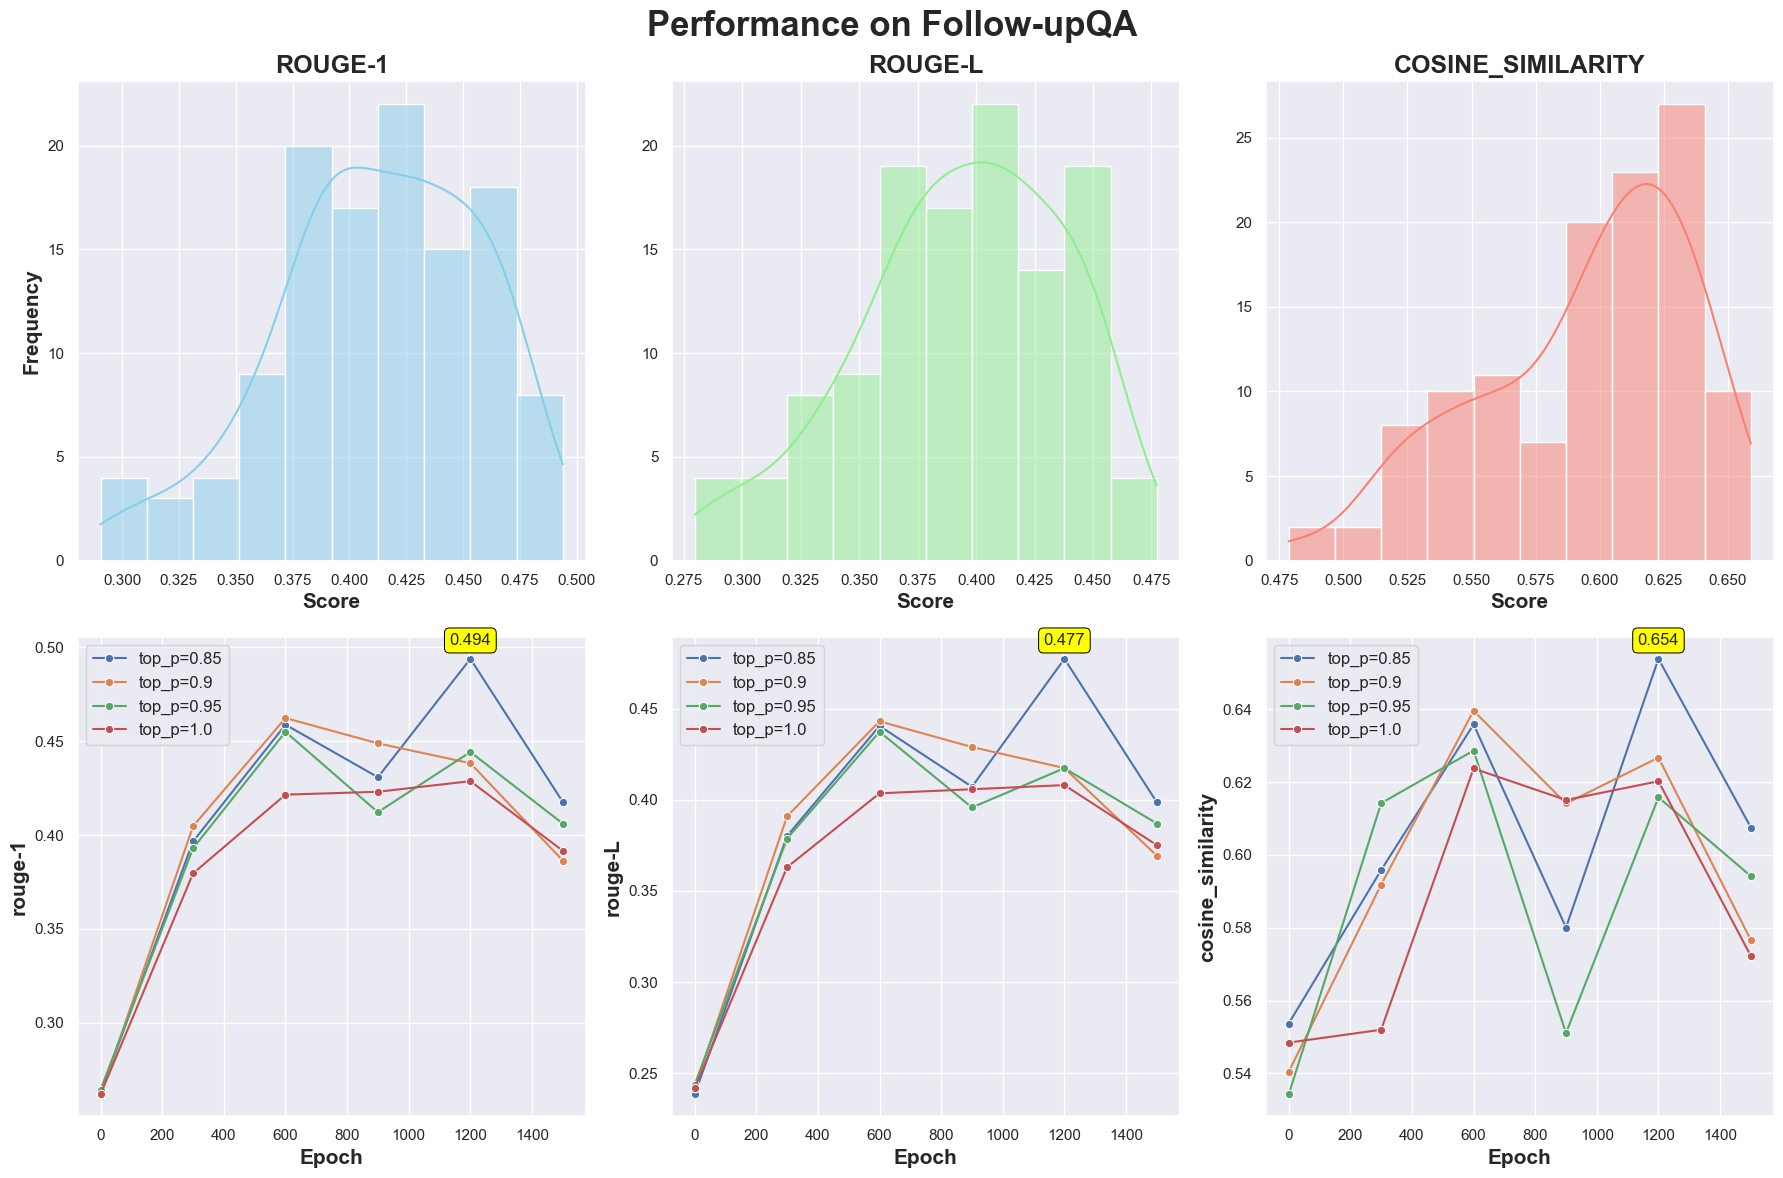

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style("darkgrid")

top_p_values = [0.85, 0.9, 0.95, 1.0]

# Setup the figure and axes for a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

fig.suptitle('Performance on Follow-upQA', fontsize=25, fontweight='bold')

# Function to annotate the global maximum point on line plots
def annotate_global_max(data, metric, ax=None):
    # Find the global max for the metric
    global_max_value = data[metric].max()
    # Find the first instance of the global max
    max_row = data.loc[data[metric] == global_max_value].iloc[0]
    max_x = max_row['epoch']
    max_y = max_row[metric]
    text = f"{max_y:.3f}"
    if ax is None:
        ax = plt.gca()
    ax.annotate(text, xy=(max_x, max_y), xytext=(0,10), textcoords="offset points",
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
                bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=0.72), ha="center")

# First row: Histograms from script 1
no_epoch_0 = result[result['epoch'] != 0]
metrics = ['rouge-1', 'rouge-L', 'cosine_similarity']
colors = ['skyblue', 'lightgreen', 'salmon']
for i, metric in enumerate(metrics):
    sns.histplot(no_epoch_0[metric], bins=10, ax=axes[0, i], kde=True, color=colors[i])
    axes[0, i].set_title(f'{metric.upper()}', fontsize=18, fontweight='bold')
    axes[0, i].set_xlabel('Score', fontsize=15, fontweight='bold')
    axes[0, i].set_ylabel('Frequency' if i == 0 else '', fontsize=15, fontweight='bold')

# Second row: Line plots from script 2
for i, metric in enumerate(metrics):
    combined_data = pd.DataFrame()
    for tp in top_p_values:
        tp_data = result[(result['max_len'] == 50) & (result['temp'] == 0.6) & (result['top_p'] == tp)]
        combined_data = pd.concat([combined_data, tp_data])
        sns.lineplot(x='epoch', y=metric, data=tp_data, ax=axes[1, i], marker='o', label=f'top_p={tp}')
    annotate_global_max(combined_data, metric, ax=axes[1, i])
    axes[1, i].set_xlabel('Epoch', fontsize=15, fontweight='bold')
    axes[1, i].set_ylabel(metric, fontsize=15, fontweight='bold')
    axes[1, i].legend(loc='upper left', fontsize=12)

# Adjusting layout
plt.tight_layout()

# Save the figure
fig.savefig('images/combined_performance_metrics.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()
